In [91]:
%matplotlib inline

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [93]:
plt.style.use("seaborn")

In [94]:
lab_results = pd.read_csv("bt_dir_finding_lab_results.csv")
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation
0,0.00,0.00,0.0,-5,1
1,4.99,0.00,0.0,40,30
2,10.20,0.00,0.0,-50,0
3,13.30,0.00,0.0,-50,30
4,0.00,4.02,0.0,-5,-36


In [95]:
lab_results["expected_azimuth"] = np.rad2deg(
    np.arctan2(lab_results["x"], lab_results["y"])
)
lab_results["expected_elevation"] = np.rad2deg(
    np.arctan2(lab_results["z"], np.sqrt(lab_results["x"] ** 2 + lab_results["y"] ** 2))
)
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation,expected_azimuth,expected_elevation
0,0.00,0.00,0.0,-5,1,0.0,0.0
1,4.99,0.00,0.0,40,30,90.0,0.0
2,10.20,0.00,0.0,-50,0,90.0,0.0
3,13.30,0.00,0.0,-50,30,90.0,0.0
4,0.00,4.02,0.0,-5,-36,0.0,0.0


In [157]:
lab_results["azimuth_delta"] = np.abs(
    lab_results["expected_azimuth"] - lab_results["measured_azimuth"]
)
lab_results["elevation_delta"] = np.abs(
    lab_results["expected_elevation"] - lab_results["measured_elevation"]
)
lab_results["delta"] = np.sqrt(
    lab_results["azimuth_delta"] ** 2 + lab_results["elevation_delta"] ** 2
)
lab_results.head()

158.7734234687909

Measured azimuth error

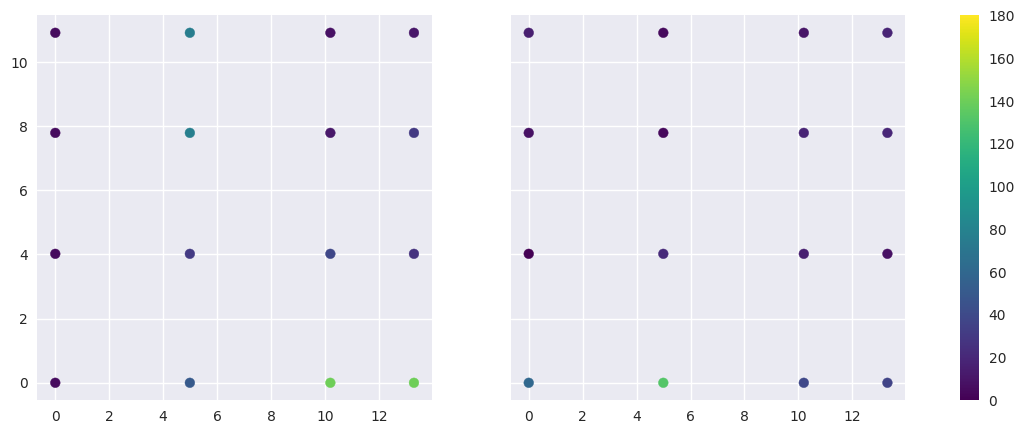

In [100]:
zeroed_target = lab_results[lab_results["z"] == 0]
elevated_target = lab_results[lab_results["z"] == 5.3]


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for i, dataset in enumerate([zeroed_target, elevated_target]):
    img = axs[i].scatter(
        dataset["x"],
        dataset["y"],
        c=dataset["azimuth_delta"],
        vmin=0,
        vmax=180,
        cmap="viridis"
    )
fig.colorbar(img, ax=axs);

Measured elevation error

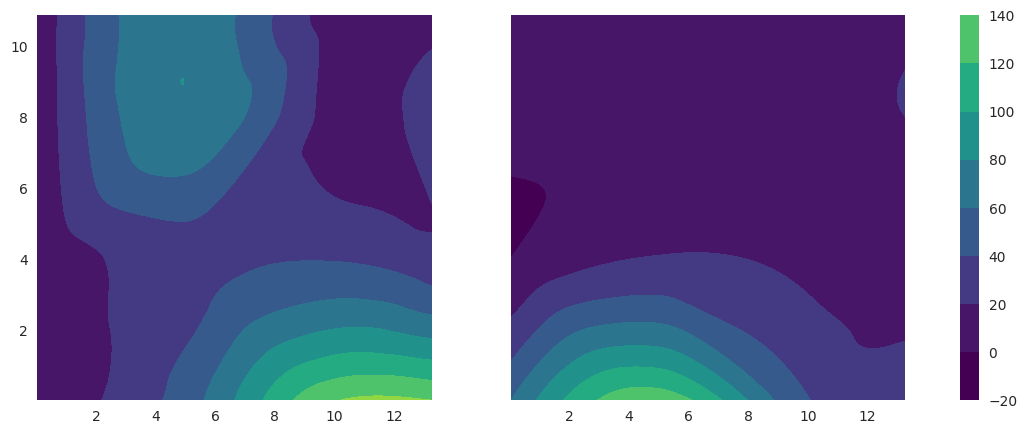

In [101]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for i, dataset in enumerate([zeroed_target, elevated_target]):
    points = dataset[["x", "y"]]
    x_max = dataset["x"].max()
    y_max = dataset["y"].max()

    grid_x, grid_y = np.mgrid[0:x_max:250j, 0:y_max:250j]
    interpolated = griddata(
        points, dataset["azimuth_delta"], (grid_x, grid_y), method="cubic"
    )
    img = axs[i].contourf(
        interpolated.T,
        vmin=0,
        vmax=160,
        extent=(0, x_max, 0, y_max),
        origin="lower",
        cmap="viridis",
    )
fig.colorbar(img, ax=axs)


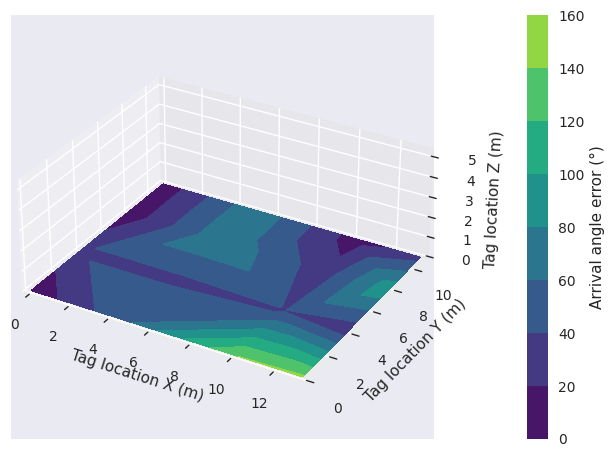

In [156]:
points = lab_results[["x", "y", "z"]]

x_max = lab_results["x"].max()
y_max = lab_results["y"].max()
z_max = lab_results["z"].max()

xs = np.linspace(0, x_max, 250)
ys = np.linspace(0, y_max, 250)
zs = np.linspace(0, z_max, 100)
grid_x, grid_y, grid_z = np.meshgrid(xs, ys, zs)

interpolated = griddata(
    points, lab_results["delta"], (grid_x, grid_y, grid_z), method="linear"
)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
colorbar_added = False

contourf_config = {"vmin": 0, "vmax": 160, "cmap": "viridis"}


def animate(idx_z):
    global colorbar_added
    z_idx, z = idx_z
    ax.cla()
    ax.set_xlim3d(0, x_max)
    ax.set_ylim3d(0, y_max)
    ax.set_zlim3d(0, z_max)
    ax.set_xlabel("Tag location X (m)")
    ax.set_ylabel("Tag location Y (m)")
    ax.set_zlabel("Tag location Z (m)")
    ax.set_box_aspect((x_max, y_max, z_max))
    if z_idx > 1:
        ax.contourf(
            grid_x[0, :, : z_idx + 1],
            interpolated[0, :, : z_idx + 1],
            grid_z[0, :, : z_idx + 1],
            zdir="y",
            offset=0,
            **contourf_config,
        )
        ax.contourf(
            interpolated[:, -1, : z_idx + 1],
            grid_y[:, -1, : z_idx + 1],
            grid_z[:, -1, : z_idx + 1],
            zdir="x",
            offset=x_max,
            **contourf_config
        )

    img = ax.contourf(
        grid_x[:, :, 0],
        grid_y[:, :, 0],
        interpolated[:, :, z_idx],
        zdir="z",
        offset=z,
        extent=(0, x_max, 0, y_max),
        **contourf_config
    )
    if not colorbar_added:
        colorbar_added = True
        cbar = plt.colorbar(img, ax=ax, pad=0.15)
        cbar.set_label("Arrival angle error (°)")

    return img.collections


anim = FuncAnimation(fig, animate, enumerate(zs))

anim.save("error_slice.gif", fps=30, dpi=300)